# Conversation Summaries with LangGraph

Một trong những trường hợp sử dụng phổ biến nhất của việc duy trì cuộc trò chuyện là theo dõi lịch sử cuộc trò chuyện. Bằng cách tóm tắt và tham khảo các tin nhắn trước đây, chúng ta có thể duy trì ngữ cảnh thiết yếu mà không làm quá tải hệ thống với toàn bộ cuộc trò chuyện. Điều này đặc biệt quan trọng đối với các cuộc trò chuyện dài, nơi một cửa sổ ngữ cảnh lớn có thể dẫn đến tăng chi phí tính toán và khả năng không chính xác.

Trong hướng dẫn này, chúng ta sẽ khám phá cách tóm tắt một cuộc trò chuyện và tích hợp bản tóm tắt đó vào trạng thái cuộc trò chuyện mới trong khi loại bỏ các tin nhắn cũ hơn. Cách tiếp cận này giúp quản lý độ dài cuộc trò chuyện trong một cửa sổ ngữ cảnh hạn chế, ngăn ngừa việc tăng chi phí hoặc thời gian suy luận không chủ ý.

**Các bước chính:**

1. Phát hiện xem một cuộc trò chuyện có quá dài hay không (ví dụ: dựa trên số lượng tin nhắn).
2. Nếu vượt quá ngưỡng, hãy tóm tắt cuộc trò chuyện cho đến thời điểm đó.
3. Loại bỏ các tin nhắn cũ hơn và chỉ lưu trữ bản tóm tắt (cộng với các tin nhắn gần đây nhất).

Hướng dẫn này sẽ hướng dẫn bạn thiết lập một luồng cuộc trò chuyện tự động tóm tắt các tin nhắn cũ hơn và chỉ giữ lại các lượt trò chuyện gần đây và bản tóm tắt.


## Checking the Conversation Length

Dưới đây, chúng ta thiết lập `State` tùy chỉnh của mình để lưu trữ cả tin nhắn và bản tóm tắt. Chúng ta cũng sẽ định nghĩa một hàm trợ giúp trong một **ô riêng biệt** để xác định xem cuộc trò chuyện có vượt quá độ dài nhất định hay không.

- Lớp `State` mở rộng `MessagesState`, giữ `messages` và `summary`.


---
**Note**:

Trong thư viện `typing` của Python, `Literal` được sử dụng để chỉ định một tập hợp giá trị cụ thể mà một biến có thể nhận. Nó giúp kiểm soát kiểu dữ liệu một cách chặt chẽ hơn và hỗ trợ kiểm tra kiểu tĩnh với các công cụ như `mypy`.

### Cách sử dụng `Literal`

#### 1. Giới hạn giá trị của biến
Bạn có thể sử dụng `Literal` để định nghĩa một biến chỉ có thể nhận một số giá trị cụ thể:

```python
from typing import Literal

def get_status(status: Literal["success", "error", "pending"]) -> str:
    return f"Status is {status}"

print(get_status("success"))  # ✅ Hợp lệ
print(get_status("error"))    # ✅ Hợp lệ
print(get_status("failed"))   # ❌ Lỗi kiểm tra kiểu (mypy sẽ cảnh báo)
```

`Literal` giúp làm mã nguồn an toàn hơn và dễ kiểm soát lỗi hơn, đặc biệt khi làm việc với API hoặc cấu hình có giá trị cố định.

---

In [5]:
from typing import Literal, Annotated
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, RemoveMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages

# Set up an in-memory storage for conversation states
memory = MemorySaver()

# We'll store both the conversation messages and the summary in the state
class State(MessagesState):
    messages: Annotated[list, add_messages]
    summary: str
    
model = ChatOllama(model='qwen2.5:7b', temperature=0)


Here is a separate code cell for the `should_continue` function, which checks if the conversation has more than 6 messages.

In [7]:
def should_continue(state: State) -> Literal["summarize_conversation", END]:  # type: ignore
    """
    Check if the conversation is too long (over 6 messages).
    If it is, move to the 'summarize_conversation' node.
    Otherwise, end the conversation.
    """
    messages = state['messages']
    if len(messages) > 6:
        return "summarize_conversation"
    return END
    

## Summarizing and Managing the Conversation

Khi cuộc hội thoại vượt quá ngưỡng, chúng ta sẽ tóm tắt nó và xóa các tin nhắn cũ để chỉ giữ lại một phân đoạn gần đây và bản tóm tắt tổng thể. Chúng ta cũng tạo một node (`ask_llm`) để xử lý các tin nhắn mới, tùy chọn bao gồm bản tóm tắt hiện có.

- `ask_llm` kiểm tra xem bản tóm tắt có tồn tại hay không và thêm nó vào đầu như một `SystemMessage` nếu có.


In [8]:
def ask_llm(state: State):
    """
    If a summary of the conversation already exists, we include it as a
    system message. Otherwise, we just use the existing messages.
    """
    summary = state.get('summary', '')
    
    if summary:
        system_message = f"This is the conversation summary so far: {summary}"
        messages = [SystemMessage(content=system_message)] + state['messages']
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": [response]}
    

- `summarize_conversation` tạo hoặc mở rộng bản tóm tắt và xóa các tin nhắn cũ.


In [9]:
def summarize_conversation(state: State):
    """
    Summarize the conversation in English.
    If an existing summary exists, extend it with new messages.
    Delete older messages to reduce context usage,
    keeping only the last two messages.
    """
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is the conversation summary so far:\n{summary}\n\n"
            "Please extend the summary by incorporating any new messages."
        )
    else:
        summary_message = "Please create a concise summary of the conversation so far."

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Remove older messages, except the last two
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"summary": response.content, "messages": delete_messages}

## Building Graph Workflow

Dưới đây, chúng ta xây dựng một `StateGraph`, thêm các node của chúng ta, và biên dịch ứng dụng. Chúng ta cũng sử dụng `visualize_graph(app)` để xem cấu trúc của workflow.

- Sử dụng `StateGraph` để định nghĩa các node và edges.
- Sử dụng `visualize_graph(app)` để xem workflow.


In [10]:
# Build the workflow graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("conversation", ask_llm)
workflow.add_node(summarize_conversation)

# Define edges
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile with memory checkpoint
app = workflow.compile(checkpointer=memory)

Dưới đây là một đoạn mã ví dụ minh họa đồ thị workflow hiện tại. Chúng ta định nghĩa các kiểu node tùy chỉnh cho đồ thị và sau đó sử dụng các tiện ích IPython để hiển thị hình ảnh đã được render nội tuyến. Data class `NodeStyles` tùy chỉnh màu nền, kiểu đường viền và giao diện tổng thể của các node.


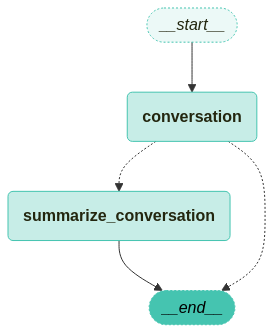

In [11]:
# Required imports for graph visualization
from IPython.display import Image, display
from dataclasses import dataclass


@dataclass
class NodeStyles:
    """
    A data class defining styles for graph nodes.
    """

    # Style for default nodes
    default: str = (
        "fill:#45C4B0, fill-opacity:0.3, color:#23260F, "
        "stroke:#45C4B0, stroke-width:1px, font-weight:bold, line-height:1.2"
    )
    # Style for first node (e.g., start node)
    first: str = (
        "fill:#45C4B0, fill-opacity:0.1, color:#23260F, "
        "stroke:#45C4B0, stroke-width:1px, font-weight:normal, "
        "font-style:italic, stroke-dasharray:2,2"
    )
    # Style for last node (e.g., end node)
    last: str = (
        "fill:#45C4B0, fill-opacity:1, color:#000000, "
        "stroke:#45C4B0, stroke-width:1px, font-weight:normal, "
        "font-style:italic, stroke-dasharray:2,2"
    )


# Display the workflow graph with the defined node styles
display(
    Image(
        app.get_graph().draw_mermaid_png(
            background_color="white", node_colors=NodeStyles()
        )
    )
)

## Running Workflow

Bạn có thể tương tác với ứng dụng bằng cách gửi tin nhắn. Khi cuộc trò chuyện vượt quá 6 tin nhắn, nó sẽ tự động tóm tắt và rút gọn.

- Phương thức `app.stream` xử lý việc truyền phát (streaming) tin nhắn và kích hoạt các node tương ứng.
- Kiểm tra trạng thái nội bộ với `app.get_state(config)` để xem tin nhắn và bản tóm tắt được cập nhật như thế nào.


Here is a helper function, `print_update`, which prints updates in real time during streaming.

In [12]:
def print_update(update):
    """
    Helper function to print out updates during streaming.
    """
    for k, v in update.items():
        for m in v.get("messages", []):
            m.pretty_print()
        if "summary" in v:
            print(v["summary"])

Dưới đây là một cell mã đơn lẻ minh họa cách chúng ta xử lý tin nhắn người dùng và xử lý chúng thông qua chế độ streaming. Chúng ta import `HumanMessage`, cấu hình session với một thread ID, và gửi ba tin nhắn người dùng theo trình tự. Sau mỗi tin nhắn, các cập nhật được streaming và in ra theo thời gian thực.


In [13]:
from langchain_core.runnables import RunnableConfig
# Initialize a configuration object with thread ID
# config = {"configurable": {"thread_id": "1"}}
config = RunnableConfig(configurable={"thread_id": "1"})

# 1) First user message
input_message = HumanMessage(content="Hello! Nice to meet you. My name is Dino.")
input_message.pretty_print()

# Process the first message in streaming mode and print updates
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

# 2) Second user message
input_message = HumanMessage(content="Do you remember my name?")
input_message.pretty_print()

# Process the second message in streaming mode and print updates
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

# 3) Third user message
input_message = HumanMessage(content="I am working as an AI researcher.")
input_message.pretty_print()

# Process the third message in streaming mode and print updates
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Hello! Nice to meet you. My name is Dino.
================================== Ai Message ==================================

Hello Dino, nice to meet you too! How can I assist you today? Feel free to ask me any questions or let me know if there's anything specific you'd like to discuss.
================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Dino. It's nice to see you again! Is there anything in particular you'd like to talk about or any questions you have?
================================ Human Message =================================

I am working as an AI researcher.
================================== Ai Message ==================================

That's great to hear! As an AI researcher, you must be at the forefront of innovation and develop

In [14]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Hello! Nice to meet you. My name is Dino.', additional_kwargs={}, response_metadata={}, id='97115ec8-29ac-436e-87b8-8803aa2aea0c'),
  AIMessage(content="Hello Dino, nice to meet you too! How can I assist you today? Feel free to ask me any questions or let me know if there's anything specific you'd like to discuss.", additional_kwargs={}, response_metadata={'model': 'qwen2.5:7b', 'created_at': '2025-03-24T16:38:34.279852Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7880494600, 'load_duration': 6877948400, 'prompt_eval_count': 42, 'prompt_eval_duration': 368879500, 'eval_count': 40, 'eval_duration': 628920600, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-f4ddde7d-5aa7-4296-8fc2-b59d93087e17-0', usage_metadata={'input_tokens': 42, 'output_tokens': 40, 'total_tokens': 82}),
  HumanMessage(content='Do you remember my name?', additional_kwargs={}, response_metadata={}, id='f64ebaae-f1e0-470c-95a

In [15]:
# Create a new user message
input_message = HumanMessage(
    content="I'm recently learning more about LLMs. I'm reading the latest papers on LLM."
)

# Display the message content
input_message.pretty_print()

# Process and print updates in streaming mode
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

I'm recently learning more about LLMs. I'm reading the latest papers on LLM.
================================== Ai Message ==================================

That sounds fascinating! Large Language Models (LLMs) are indeed a hot topic in AI research, and there's always new and exciting developments happening in this field.

What specific aspects of LLMs are you finding particularly interesting? Are there any particular challenges or advancements that you're focusing on in your reading? For example, topics like:

- **Model Architecture**: How the architecture of these models is evolving.
- **Training Techniques**: New methods for training large language models more efficiently.
- **Evaluation Metrics**: New ways to evaluate the performance and effectiveness of LLMs.
- **Applications**: Innovative applications of LLMs in various domains such as natural language understanding, generation, translation, etc.


In [16]:
# Check the conversation state again to see the new summary
values = app.get_state(config).values
values

{'messages': [HumanMessage(content="I'm recently learning more about LLMs. I'm reading the latest papers on LLM.", additional_kwargs={}, response_metadata={}, id='dbb2a10b-36ad-4007-bf29-da94d0da4ac1'),
  AIMessage(content="That sounds fascinating! Large Language Models (LLMs) are indeed a hot topic in AI research, and there's always new and exciting developments happening in this field.\n\nWhat specific aspects of LLMs are you finding particularly interesting? Are there any particular challenges or advancements that you're focusing on in your reading? For example, topics like:\n\n- **Model Architecture**: How the architecture of these models is evolving.\n- **Training Techniques**: New methods for training large language models more efficiently.\n- **Evaluation Metrics**: New ways to evaluate the performance and effectiveness of LLMs.\n- **Applications**: Innovative applications of LLMs in various domains such as natural language understanding, generation, translation, etc.\n\nFeel fr

Như bạn có thể thấy, bản tóm tắt đã được thêm vào, và các tin nhắn cũ hơn đã được thay thế bằng các hành động `RemoveMessage`. Chỉ còn lại các tin nhắn gần đây nhất và bản tóm tắt mới được tạo.

Bây giờ bạn có thể tiếp tục cuộc trò chuyện, và mặc dù chỉ có hai tin nhắn cuối cùng hiển thị, hệ thống vẫn giữ lại ngữ cảnh tổng thể thông qua bản tóm tắt.


In [17]:
# Create a user message asking if the assistant remembers the user's name
input_message = HumanMessage(content="Do you remember my name?")
input_message.pretty_print()

# Process in streaming mode
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

I don't have a record of your name from previous interactions. If you'd like to introduce yourself again, that would be great! For now, let's continue our discussion about LLMs. You mentioned you're reading the latest papers on them. Are there any specific areas or challenges in LLMs that particularly interest you?


In [18]:
# Create another user message asking about the user's occupation
input_message = HumanMessage(content="Do you also recall my occupation?")
input_message.pretty_print()

# Process in streaming mode
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Do you also recall my occupation?
================================== Ai Message ==================================

I don't have a record of your occupation from previous interactions. If you'd like to share it, that would be helpful! Otherwise, let's continue our discussion about Large Language Models (LLMs). You mentioned you are reading the latest papers on LLMs. Are there any specific areas or challenges in LLMs that particularly interest you?
